In [92]:
import numpy as np
import pandas as pd
import hmmlearn
import matplotlib.pyplot as plt
import pickle

### Section - look at the average time spent in each state over time 

In [2]:
labels = ['deep sleep', 'light sleep', 'quiet awake', 'active awake']
colours = ['darkblue', 'lightblue', 'orange', 'red']

In [3]:
df = pd.read_pickle('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/admin/cleaned_data.pkl')

In [4]:
import sys
 
sys.path.append('../src/HMM')

In [5]:
from hmm import HMM

In [6]:
hdf = HMM(data = df)

In [8]:
h = pickle.load(open("/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/admin/4_state_model.pkl", "rb"))

In [10]:
hdf.hmm_display(h, states=labels, observables=['d', 'd', 'd'])

Starting probabilty table: 
|    |   deep sleep |   light sleep |   quiet awake |   active awake |
|----|--------------|---------------|---------------|----------------|
|  0 |  9.16335e-07 |    0.00360959 |     0.0726832 |       0.923706 |

Transition probabilty table: 
|              |   deep sleep |   light sleep |   quiet awake |   active awake |
|--------------|--------------|---------------|---------------|----------------|
| deep sleep   |     0.378715 |      0.370866 |      0.250418 |      0         |
| light sleep  |     0.675743 |      0.214734 |      0.109523 |      0         |
| quiet awake  |     0        |      0.277988 |      0.685271 |      0.0367412 |
| active awake |     0        |      0        |      0.048608 |      0.951392  |

Emission probabilty table: 
|              |         d |         d |        d |
|--------------|-----------|-----------|----------|
| deep sleep   | 1         | 0         | 0        |
| light sleep  | 1         | 0         | 0        |
| qui

In [9]:
hdf['moving'] = np.where(hdf['moving'] == True, 1, 0)

In [33]:
import pandas as pd
import numpy as np 
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from hmmlearn import hmm
from math import floor, ceil
from functools import partial

from misc import bin_data
from hmm_functions import hmm_pct_state

In [24]:
def hmm_decode(d, h, b, var, fun, t= 't', return_type = 'array'):

    # bin the data to 60 second intervals with a selected column and function on that column
    bin_df = d.groupby('id', group_keys = False).apply(partial(bin_data,
                                                                column = var, 
                                                                bin_column = t,
                                                                function = fun, 
                                                                bin_secs = b
    ))

    gb = bin_df.groupby(bin_df.index)[f'{var}_{fun}'].apply(list)
    time_list = bin_df.groupby(bin_df.index)['t_bin'].apply(list)

    # logprob_list = []
    states_list = []
    df = pd.DataFrame()

    for i, t, id in zip(gb, time_list, time_list.index):
        seq_o = np.array(i)
        seq = seq_o.reshape(-1, 1)
        logprob, states = h.decode(seq)

        #logprob_list.append(logprob)
        if return_type == 'array':
            states_list.append(states)
        if return_type == 'table':
            label = [id] * len(t)
            # previous_state = np.array(states[:-1], dtype = float)
            # previous_state = np.insert(previous_state, 0, np.nan)
            all = zip(label, t, states, seq_o)
            all = pd.DataFrame(data = all)
            df = pd.concat([df, all], ignore_index = False)
    
    if return_type == 'array':
        return states_list, time_list #, logprob_list
    if return_type == 'table':
        df.columns = ['id', 'bin', 'state', var]
        return df

In [94]:
def plot_hmm_overtime(df, hmm, variable, labels, colours, wrapped = False, tbin = 60, func = 'max', avg_window = 30, title = ''):
    """
    Creates a plot of all states overlayed with y-axis shows the liklihood of being in a sleep state and the x-axis showing time in hours.
    The plot is generated through the plotly package

    Args:
        hmm (hmmlearn trained hmm): This should be a trained HMM Learn object with the correct hidden states and emission states for your dataset
        @variable = string, the column heading of the variable of interest. Default is "moving"
        @labels = list[string], the names of the different states present in the hidden markov model. If None the labels are assumed to be ['Deep sleep', 'Light sleep', 'Quiet awake', 'Full awake']
        @colours = list[string], the name of the colours you wish to represent the different states, must be the same length as labels. If None the colours are a default for 4 states (blue and red)
        It accepts a specific colour or an array of numbers that are acceptable to plotly
        @wrapped = bool, if True the plot will be limited to a 24 hour day average
        @tbin = int, the time in seconds you want to bin the movement data to, default is 60 or 1 minute
        @func = string, when binning to the above what function should be applied to the grouped data. Default is "max" as is necessary for the "moving" variable
        @avg_window, int, the window in minutes you want the moving average to be applied to. Default is 30 mins
    """

    df = df.copy(deep = True).reset_index()

    list_states = list(range(len(h.transmat_)))
    if len(list_states) != len(labels):
        raise RuntimeError('The number of labels do not match the number of states in the model')

    states_list, time_list = hmm_decode(df, hmm, tbin, variable, func)

    df = pd.DataFrame()
    for l, t in zip(states_list, time_list):
        tdf = hmm_pct_state(l, t, list(range(len(labels))), avg_window = int((avg_window * 60)/tbin))
        df = pd.concat([df, tdf], ignore_index = True)

    if wrapped is True:
        df['t'] = df['t'].map(lambda t: t % (60*60*24))

    df['t'] = df['t'] / (60*60)
    t_min = int(12 * floor(df.t.min() / 12))
    t_max = int(12 * ceil(df.t.max() / 12))    
    t_range = [t_min, t_max]  

    for c, (col, n) in enumerate(zip(colours, labels)):

        column = f'state_{c}'

        gb_df = df.groupby('t').agg(**{
                    'mean' : (column, 'mean'), 
                    'SD' : (column, 'std'),
                    'count' : (column, 'count')
                })

        gb_df['SE'] = (1.96*gb_df['SD']) / np.sqrt(gb_df['count'])
        gb_df['y_max'] = gb_df['mean'] + gb_df['SE']
        gb_df['y_min'] = gb_df['mean'] - gb_df['SE']
        gb_df = gb_df.reset_index()

        plt.plot(gb_df['t'], gb_df['mean'], color = col, label = n)
        plt.fill_between(gb_df['t'], gb_df['y_min'], gb_df['y_max'], color=col, alpha=0.25)

    plt.legend(loc="upper right")
    plt.ylabel('% time in state')
    plt.xlabel('time (hours)')
    plt.ylim((0,1))

    plt.show()

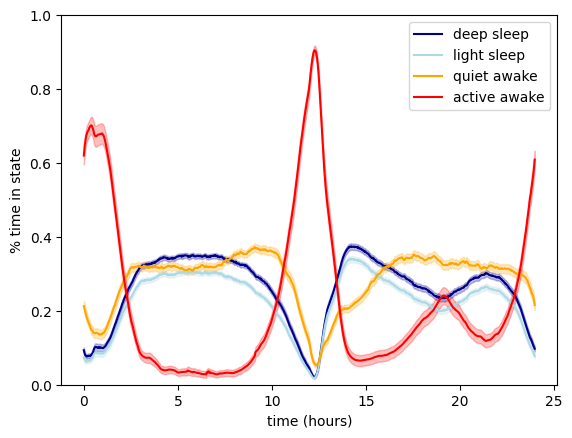

In [95]:
plot_hmm_overtime(hdf, h, 'hmm', labels, colours, wrapped = True)

In [135]:
def plot_hmm_quantify(df, hmm, variable, labels, colours, tbin = 60, func = 'max', title = '', grids = False):
    """
    
    """

    df = df.copy(deep = True).reset_index()

    states_list, time_list = hmm_decode(df, hmm, tbin, variable, func)
    list_states = list(range(len(h.transmat_)))
    if len(list_states) != len(labels):
        raise RuntimeError('The number of labels do not match the number of states in the model')
    label_dict  = {k : v for k, v in zip(list_states, labels)}

    rows = []
    for array in states_list:
        unique, counts = np.unique(array, return_counts=True)
        row = dict(zip(unique, counts))
        rows.append(row)
    counts_all =  pd.DataFrame(rows)
    counts_all['sum'] = counts_all.sum(axis=1)
    counts_all = counts_all.iloc[:, list_states[0]: list_states[-1]+1].div(counts_all['sum'], axis=0)
    counts_all.fillna(0, inplace = True)

    d = pd.melt(counts_all)
    d['State'] = d['variable'].map(label_dict)
    sns.set_style("whitegrid")
    ax = sns.swarmplot(data = d, x="State", y="value", hue = 'State', palette=colours, legend = False, size=3)
    ax = sns.boxplot(data = d, x="State", y="value", hue = 'State', palette=colours, showcaps=False, showfliers=False, whiskerprops={'linewidth':0})

    ax.set(ylabel = '% of time in state')
    ax.set(ylim=(0, 1))

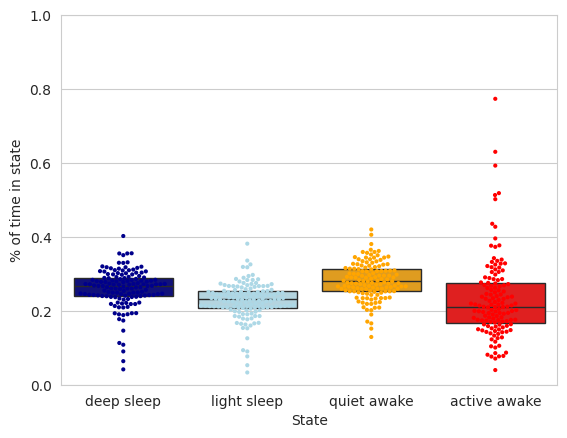

In [136]:
plot_hmm_quantify(hdf, h, 'hmm', labels, colours)

### Section - Look at the raw data visualised

In [142]:
import random

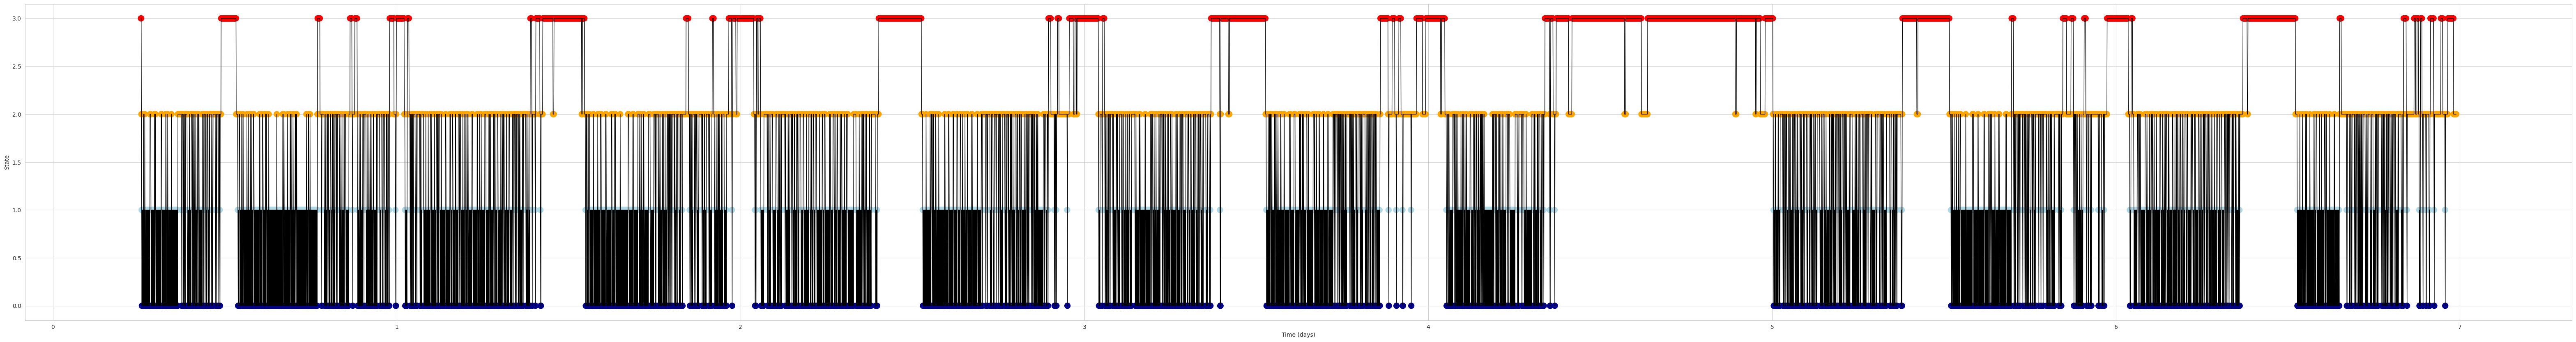

In [206]:
def plot_hmm_raw(df, hmm, variable, colours, tbin = 60, func = 'max'):
        
    df = df.copy(deep = True).reset_index()

    states_list, time_list = hmm_decode(df, hmm, tbin, variable, func)
    time_list = list(time_list)
    list_states = list(range(len(h.transmat_)))
    if len(list_states) != len(colours):
        raise RuntimeError('The number of colours do not match the number of states in the model')
    label_dict  = {k : v for k, v in zip(list_states, labels)}
    
    rand_ind = random.choice(list(range(0,len(states_list))))

    st = states_list[rand_ind]
    time = time_list[rand_ind]
    time = np.array(time) / 86400

    for c, i in enumerate(colours):
        if c == 0:
            col = np.where(st == c, colours[c], np.NaN)
        else:
            col = np.where(st == c, colours[c], col)

    plt.figure(figsize=(80,10))

    plt.scatter(time, st, s = 50*2, marker='o', c=col)
    plt.plot(time, st, marker='o', markersize = 0, mfc='white', mec='white', c='black', lw = 1, ls = '-')

    plt.xlabel('Time (days)')
    plt.ylabel('State')

plot_hmm_raw(hdf, h, 'hmm', colours)